In [166]:
from progressbar import AnimatedMarker, Bar, BouncingBar, Counter, ETA, \
    FileTransferSpeed, FormatLabel, Percentage, \
    ProgressBar, ReverseBar, RotatingMarker, \
    SimpleProgress, Timer, AdaptiveETA, AdaptiveTransferSpeed

examples = []

import sys
import time

In [167]:
%matplotlib inline

from numpy.fft import fft
import theano
import cPickle
import numpy as np
from theano import tensor, function
from pylab import imshow
from pylab import rcParams

from agnez.weight import grid2d
from fuel.datasets import MNIST
from fuel.streams import DataStream
from fuel.transformers import Mapping
from fuel.schemes import SequentialScheme
from blocks.bricks.cost import MisclassificationRate

from blocks_contrib.probability import Pserver
from blocks_contrib.datasets import rotated_dataset, Meanizer

import seaborn as sns
sns.set_style('dark')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier as KNC

In [168]:
def _circshift(data):
    b = data[0]
    for i in range(data[0].shape[1]):
        bi = data[0][:, i, :]
        bi[10:] = 0
        #bi[:, 10:] = 0*bi[:, 10:]
        n = np.random.randint(0, 20, 1)
        b[:, i, :] = np.roll(bi, n, axis=0)
    return (b, data[1])

In [174]:
    leng = 600
    batch_size=100
    mnist_test = MNIST("test", stop=leng)
    teststream = Mapping(DataStream(mnist_test,
                             iteration_scheme=SequentialScheme(
                                 leng,
                                 batch_size)), rotated_dataset(20))
    teststream = Mapping(teststream, _circshift)
    
    mnist_train = MNIST("train", stop=4*leng)
    trainstream = Mapping(DataStream(mnist_train,
                             iteration_scheme=SequentialScheme(
                                 4*leng,
                                 batch_size)), rotated_dataset(20))
    trainstream = Mapping(trainstream, _circshift)
    # meanizer = Meanizer(trainstream)
    # trainstream = Mapping(trainstream, meanizer.meanless)
    # teststream = Mapping(teststream, meanizer.meanless)

#### Load models and data

In [175]:
def autocorrentropy(X, sigma=1):
    b, t, d = X.shape
    V = np.zeros((b, t))
    nor = np.sqrt(2*np.pi)*sigma
    dem = 2*sigma**2
    for i in range(b):
        for j in range(t):
            V[i, j] = np.exp((-(X[i, :(t-j)]-X[i, j:])**2).sum() / dem / (t-j)) / nor
    return V

def autocorrentropy2(X, sigma=1):
    b, t, d = X.shape
    V = np.zeros((b, t, d))
    nor = np.sqrt(2*np.pi)*sigma
    dem = 2*sigma**2
    for i in range(b):
        for j in range(t):
            V[i, j, :] = np.exp((-(X[i, :(t-j), :]-X[i, j:, :])**2) / dem).sum(axis=0) / (t-j)
            #V[i, j, :] = ((X[i, :(t-j), :]-X[i, j:, :])**2).sum(axis=0)
    return V


def example(fn):
    def wrapped(X):
        try:
            sys.stdout.write('Running: %s\n' % fn.__name__)
            V = fn(X)
            sys.stdout.write('\n')
        except KeyboardInterrupt:
            sys.stdout.write('\nSkipping example.\n\n')
        return V

    examples.append(wrapped)
    return wrapped

@example
def crosscorrelation(X):
    b, t, d = X.shape
    V = np.zeros((b, b))
    v1 = np.zeros(t)
    v2 = np.zeros(t)
    with ProgressBar(maxval=b) as progress:
        for i in range(b):
            progress.update(i)
            for j in range(b):
                for k in range(0):
                    v1[k] = ((X[i, :(t-k), :] - X[j, k:, :])**2 / (t-k)).sum()
                    v2[k] = ((X[i, k:, :] - X[j, :(t-k), :])**2 / (t-k)).sum()
                V[i, j] = v1[0] #+v2[0]/2#(v1+v2).min() / 2
    return V

@example
def crosscorrentropy(X, sigma=1):
    b, t, d = X.shape
    V = np.zeros((b, b))
    v1 = np.zeros(t)
    v2 = np.zeros(t)
    nor = np.sqrt(2*np.pi)*sigma
    dem = 2*sigma**2
    with ProgressBar(maxval=b) as progress:
        for i in range(b):
            progress.update(i)
            for j in range(b):
                for k in range(t):
                    v1[k] = np.exp(-((X[i, :(t-k), :] - X[j, k:, :])**2 / (t-k)).sum() / dem) / nor
                    v2[k] = np.exp(-((X[i, k:, :] - X[j, :(t-k), :])**2 / (t-k)).sum() / dem) / nor
                V[i, j] = (v1+v2).max() / 2
    return V

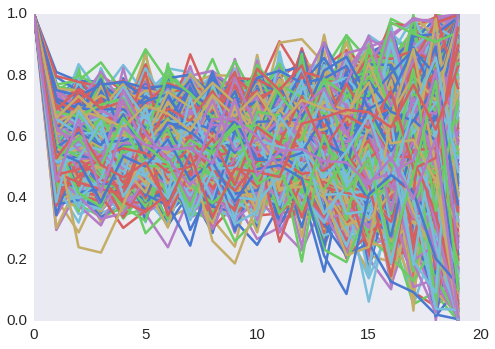

In [176]:
X = np.random.normal(0, 1, (100, 20, 784))
V = autocorrentropy2(X)
_ = plt.plot(V[1])

In [62]:
V = crosscorrentropy(X)
print V.shape

 99% (99 of 100) |####################### | Elapsed Time: 0:00:20 ETA:  0:00:00

Running: crosscorrentropy

(100, 100)


100% (100 of 100) |#######################| Elapsed Time: 0:00:21 Time: 0:00:21


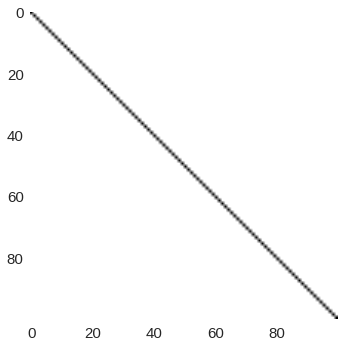

In [7]:
imshow(V)

In [177]:
z = np.zeros((leng, 20))
x = np.zeros((leng, 20*784))
y = np.zeros((leng, 20*784))

labels = np.zeros(leng)

sigma=.1
for i,b in enumerate(teststream.get_epoch_iterator()):
    first = i*100
    last = (i+1)*100
    data = b[0].transpose(1, 0, 2)
    z[first:last] = autocorrentropy(data, sigma=sigma)
    x[first:last] = data.reshape((100, -1))
    y[first:last] = autocorrentropy2(data, sigma=sigma).reshape((100, -1))
    labels[first:last] = b[1][:,0]
    
labels = labels.astype('int')

In [178]:
zt = np.zeros((4*leng, 20))
xt = np.zeros((4*leng, 20*784))
yt = np.zeros((4*leng, 20*784))

labelst = np.zeros(4*leng)

for i,b in enumerate(trainstream.get_epoch_iterator()):
    first = i*100
    last = (i+1)*100
    data = b[0].transpose(1, 0, 2)
    zt[first:last] = autocorrentropy(data, sigma=sigma)
    xt[first:last] = data.reshape((100, -1))
    yt[first:last] = autocorrentropy2(data, sigma=sigma).reshape((100, -1))
    labelst[first:last] = b[1][:,0]
    
labels = labels.astype('int')

###clf 

In [164]:
clf1 = KNC(n_neighbors=1).fit(zt, labelst)
clf2 = KNC(n_neighbors=1).fit(yt, labelst)
clf3 = KNC(n_neighbors=1).fit(xt, labelst)

In [182]:
print clf1.score(z, labels)
print clf2.score(y, labels)
print clf3.score(x, labels)

0.0866666666667
0.86
0.766666666667


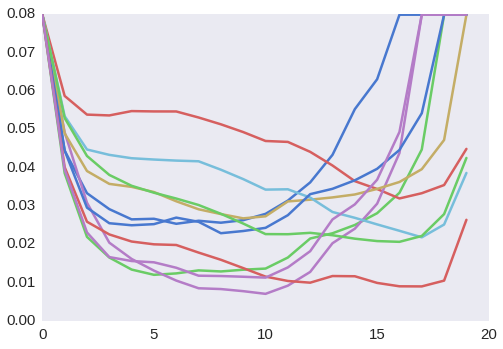

In [138]:
plt.plot(z[:10].T)

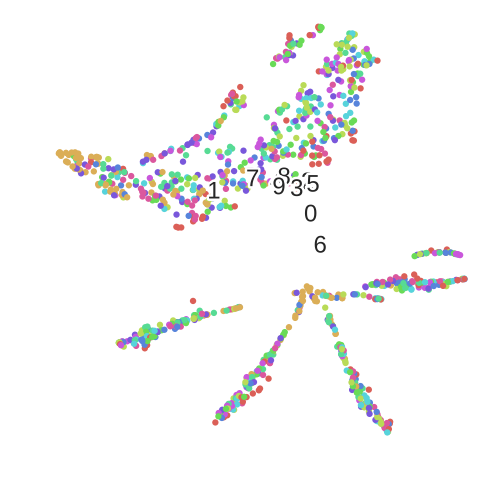

In [139]:
from sklearn.manifold.t_sne import TSNE

from agnez import embedding2d, embedding2dplot
tsne = TSNE(perplexity=40)
ebd, tsne = embedding2d(z, method=tsne)
_ = embedding2dplot(ebd, labels)

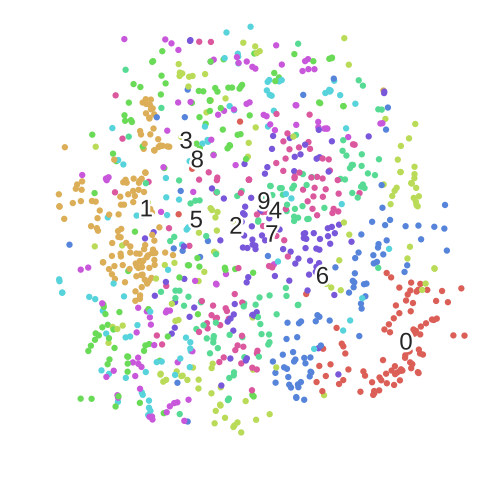

In [140]:
tsne = TSNE(perplexity=40)
ebd, tsne = embedding2d(y, method=tsne)
_ = embedding2dplot(ebd, labels)

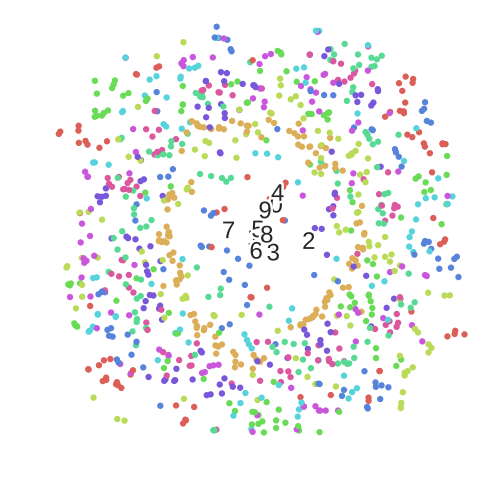

In [135]:
tsne = TSNE(perplexity=40)
ebd, tsne = embedding2d(x, method=tsne)
_ = embedding2dplot(ebd, labels)

# Cross-correntropy

In [46]:
from sklearn.manifold.t_sne import TSNE
from agnez import embedding2d, embedding2dplot

In [47]:
x = np.zeros((leng, 20, 784))
labels = np.zeros(leng)
for i,b in enumerate(teststream.get_epoch_iterator()):
    first = i*100
    last = (i+1)*100
    data = b[0].transpose(1, 0, 2)
    x[first:last] = data
    labels[first:last] = b[1][:,0]
print x.shape
labels = labels.astype('int')

(1000, 20, 784)


In [38]:
V = crosscorrentropy(x)

  0% (5 of 1000) |                        | Elapsed Time: 0:00:09 ETA:  0:31:00

Running: crosscorrentropy

Skipping example.



100% (1000 of 1000) |#####################| Elapsed Time: 0:00:10 Time: 0:00:10


UnboundLocalError: local variable 'V' referenced before assignment

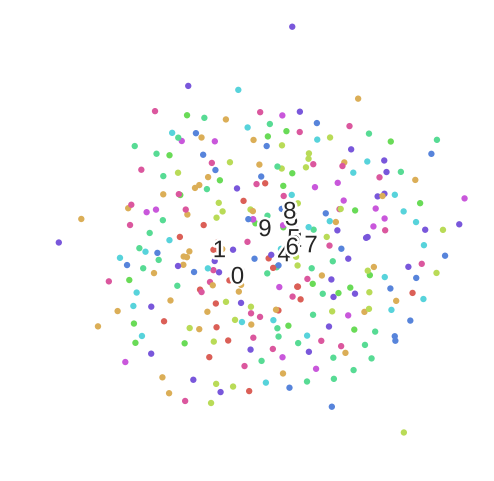

In [10]:
tsne = TSNE(perplexity=40, metric='precomputed')
ebd, tsne = embedding2d(V, method=tsne)
_ = embedding2dplot(ebd, labels)

In [45]:
V = crosscorrelation(x)

 96% (960 of 1000) |##################### | Elapsed Time: 0:00:00 ETA:  0:00:00

Running: crosscorrelation



100% (1000 of 1000) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.036629
[t-SNE] Error after 79 iterations with early exaggeration: 23.387042
[t-SNE] Error after 164 iterations: 2.683896


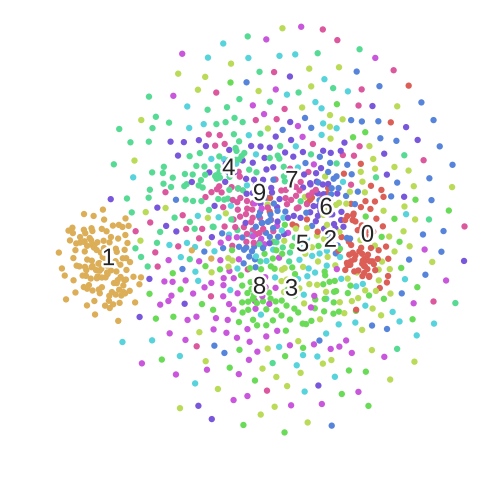

In [53]:
def V(shape, ksize=.5):
    def func(x, y, **kwargs):
        #N = len(x)
        #return ((x-y)**2).sum()
        #return (x**2).sum() + (y**2).sum() -2*(x*y).sum()
        t = shape[0]
        N = shape[1]
        x = x.reshape(shape)
        y = y.reshape(shape)
        V1 = np.zeros(t)
        V2 = np.zeros(t)
        for i in range(t):
            V1[i] = np.exp(-ksize*(x[:(t-i)] - y[i:])**2).sum() / (t-i)
            V2[i] = np.exp(-ksize*(x[i:] - y[:(t-i)])**2).sum() / (t-i)
        return N - (.5*(V1+V2)).max()
    return func

def S(shape, ksize=.5):
    def func(x, y, **kwargs):
        #N = len(x)
        #return ((x-y)**2).sum()
        #return (x**2).sum() + (y**2).sum() -2*(x*y).sum()
        t = shape[0]
        N = shape[1]
        x = x.reshape(shape)
        y = y.reshape(shape)
        X = fft(x, axis=0)
        Y = fft(y, axis=0)
        # F = ((abs(X)-abs(Y))**2).sum()
        F = abs(X * np.conj(Y)).sum()
        D = abs(X).sum() * abs(Y).sum()
        return 1 - F / D
    return func

data = x.reshape((leng, -1))
# V = ((data[:, None, :] - data)**2).sum(axis=-1)

tsne = TSNE(perplexity=40, metric=V((20,784)), verbose=True)
ebd = tsne.fit_transform(data)
cPickle.dump(ebd, file('ebd.pkl','w'))
_ = embedding2dplot(ebd, labels)

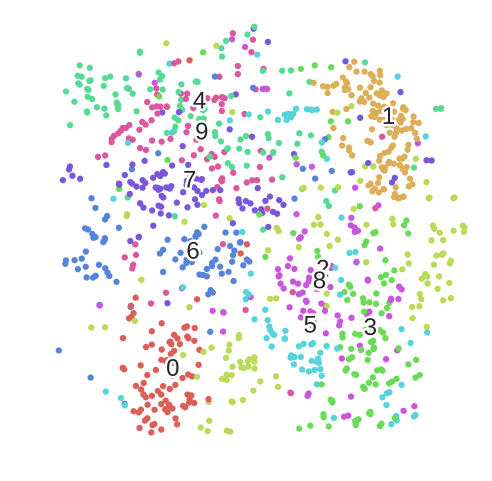

In [171]:
ebd = cPickle.load(file('ebd.pkl', 'r'))
_ = embedding2dplot(ebd, labels)

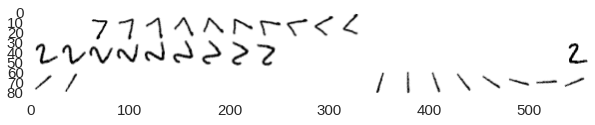

In [173]:
from agnez import image_sequence
for b in teststream.get_epoch_iterator():
    break
x = b[0]
A1 = image_sequence(x[:,0,:], (28, 28))
A2 = image_sequence(x[:,1,:], (28, 28))
A3 = image_sequence(x[:,2,:], (28, 28))
A = np.vstack([A1, A2, A3])
f = plt.figure(figsize=(10,10))
imshow(A)

In [86]:
x.shape

(20, 100, 784)